In [ ]:
import zipfile

# Specify the zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/Datasets/archive (4).zip'
extract_to = '/content/my_dataset/'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

# Check the contents of the extracted folder
import os
os.listdir(extract_to)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
import shutil
from tqdm import tqdm
from pathlib import Path
from sklearn.metrics import accuracy_score


In [ ]:
def get_dataloaders(train_dir, val_dir, test_dir, batch_size=32, image_size=(224, 224)):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
    val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [ ]:
def get_resnet_model(num_classes=10):
    model = models.resnet18(pretrained=True)  # You can use resnet50, resnet34, etc.
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify the final layer
    return model


In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    accuracy = 100 * correct_predictions.double() / total_samples

    return epoch_loss, accuracy.item()


def evaluate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    epoch_loss = running_loss / len(val_loader)
    accuracy = 100 * correct_predictions.double() / total_samples

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    return epoch_loss, accuracy.item(), all_preds, all_labels


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, batch_size=32, lr=1e-3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Evaluate
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        # Save model checkpoint
        torch.save(model.state_dict(), 'model.pth')

    # Plot train and val loss
    plt.plot(range(num_epochs), train_losses, label="Train Loss")
    plt.plot(range(num_epochs), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return model, train_losses, val_losses


In [ ]:
def save_misclassified(model, loader, device, save_path="misclassified"):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model.eval()
    misclassified_images = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Saving Misclassified Images"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            misclassified = (preds != labels)

            for i in range(inputs.size(0)):
                if misclassified[i]:
                    img = inputs[i].cpu().permute(1, 2, 0).numpy()
                    img = (img - img.min()) / (img.max() - img.min())  # Normalize
                    img_path = os.path.join(save_path, f"misclassified_{misclassified_images}.png")
                    plt.imsave(img_path, img)
                    misclassified_images += 1


In [ ]:
def test_and_save_misclassified(model, test_loader, device):
    save_misclassified(model, test_loader, device, save_path="misclassified_test")


In [ ]:
def run(train_dir, val_dir, test_dir, num_classes=10, num_epochs=10, batch_size=32, lr=1e-3, model_save_path="model.pth", misclassified_save_path="misclassified"):
    # Load the data
    train_loader, val_loader, test_loader = get_dataloaders(train_dir, val_dir, test_dir, batch_size=batch_size)

    # Initialize the model
    model = get_resnet_model(num_classes=num_classes)

    # Train the model
    print("Training the model...")
    model, train_losses, val_losses = train_model(model, train_loader, val_loader, num_epochs=num_epochs, batch_size=batch_size, lr=lr)

    # Save the final model state
    print(f"Saving the model to {model_save_path}...")
    torch.save(model.state_dict(), model_save_path)

    # Save misclassified images from the validation set
    print(f"Saving misclassified images from the validation set to {misclassified_save_path}...")
    save_misclassified(model, val_loader, device='cuda', save_path=misclassified_save_path)

    # Evaluate on the test set and save misclassified images
    print("Evaluating the model on the test set...")
    test_and_save_misclassified(model, test_loader, device='cuda')

    print("Run complete.")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 117MB/s]


Training the model...
Epoch 1/10


Evaluating: 100%|██████████| 594/594 [03:08<00:00,  3.16it/s]


Train Loss: 1.0429, Train Accuracy: 60.22%
Val Loss: 0.9287, Val Accuracy: 64.40%
Epoch 2/10


Evaluating: 100%|██████████| 594/594 [03:09<00:00,  3.13it/s]


Train Loss: 0.8307, Train Accuracy: 68.06%
Val Loss: 0.7443, Val Accuracy: 70.86%
Epoch 3/10


Evaluating: 100%|██████████| 594/594 [03:07<00:00,  3.18it/s]


Train Loss: 0.7433, Train Accuracy: 71.74%
Val Loss: 0.7279, Val Accuracy: 72.01%
Epoch 4/10


Evaluating: 100%|██████████| 594/594 [03:06<00:00,  3.18it/s]


Train Loss: 0.6692, Train Accuracy: 75.05%
Val Loss: 0.5504, Val Accuracy: 80.07%
Epoch 5/10


Evaluating: 100%|██████████| 594/594 [03:04<00:00,  3.22it/s]


Train Loss: 0.5963, Train Accuracy: 77.62%
Val Loss: 0.4982, Val Accuracy: 82.19%
Epoch 6/10


Evaluating: 100%|██████████| 594/594 [03:05<00:00,  3.21it/s]


Train Loss: 0.5101, Train Accuracy: 81.18%
Val Loss: 0.3993, Val Accuracy: 85.68%
Epoch 7/10


Evaluating: 100%|██████████| 594/594 [03:05<00:00,  3.21it/s]


Train Loss: 0.4158, Train Accuracy: 84.80%
Val Loss: 0.2574, Val Accuracy: 91.69%
Epoch 8/10


Evaluating: 100%|██████████| 594/594 [03:04<00:00,  3.22it/s]


Train Loss: 0.3175, Train Accuracy: 88.69%
Val Loss: 0.2025, Val Accuracy: 93.07%
Epoch 9/10


Evaluating: 100%|██████████| 594/594 [03:03<00:00,  3.23it/s]


Train Loss: 0.2269, Train Accuracy: 91.95%
Val Loss: 0.1356, Val Accuracy: 95.37%
Epoch 10/10


Evaluating: 100%|██████████| 594/594 [03:06<00:00,  3.19it/s]


Train Loss: 0.1669, Train Accuracy: 94.22%
Val Loss: 0.1160, Val Accuracy: 96.01%


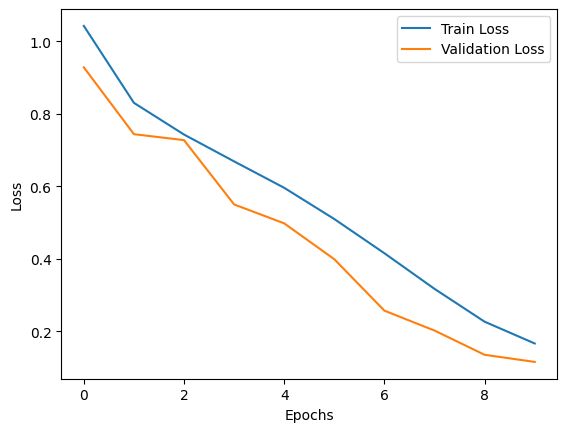

Saving the model to model.pth...
Saving misclassified images from the validation set to misclassified...


Saving Misclassified Images: 100%|██████████| 594/594 [03:30<00:00,  2.82it/s]


Evaluating the model on the test set...


Saving Misclassified Images: 100%|██████████| 170/170 [01:43<00:00,  1.64it/s]

Run complete.


In [ ]:

train_dir = '/content/my_dataset/Skin_Disease_Dataset/Train'
val_dir = '/content/my_dataset/Skin_Disease_Dataset/Train'
test_dir = '/content/my_dataset/Skin_Disease_Dataset/Test'

run(train_dir, val_dir, test_dir, num_classes=10, num_epochs=10, batch_size=32, lr=1e-3)
